## Sequential Data Prediction using RNN
#### Going to predict using trig functions

In [205]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

In [257]:
t = np.arange(0, 2000, 0.1); print(len(t))

20000


In [258]:
def trig_function(t):
    temp_sin = 3 * np.power(np.sin(t),9)
    temp_cos = 2 * np.power(np.cos(t),9)
    r = np.random.rand(len(t))
    return temp_sin + temp_cos + 2*r

In [259]:
trig_data_original = trig_function(t)

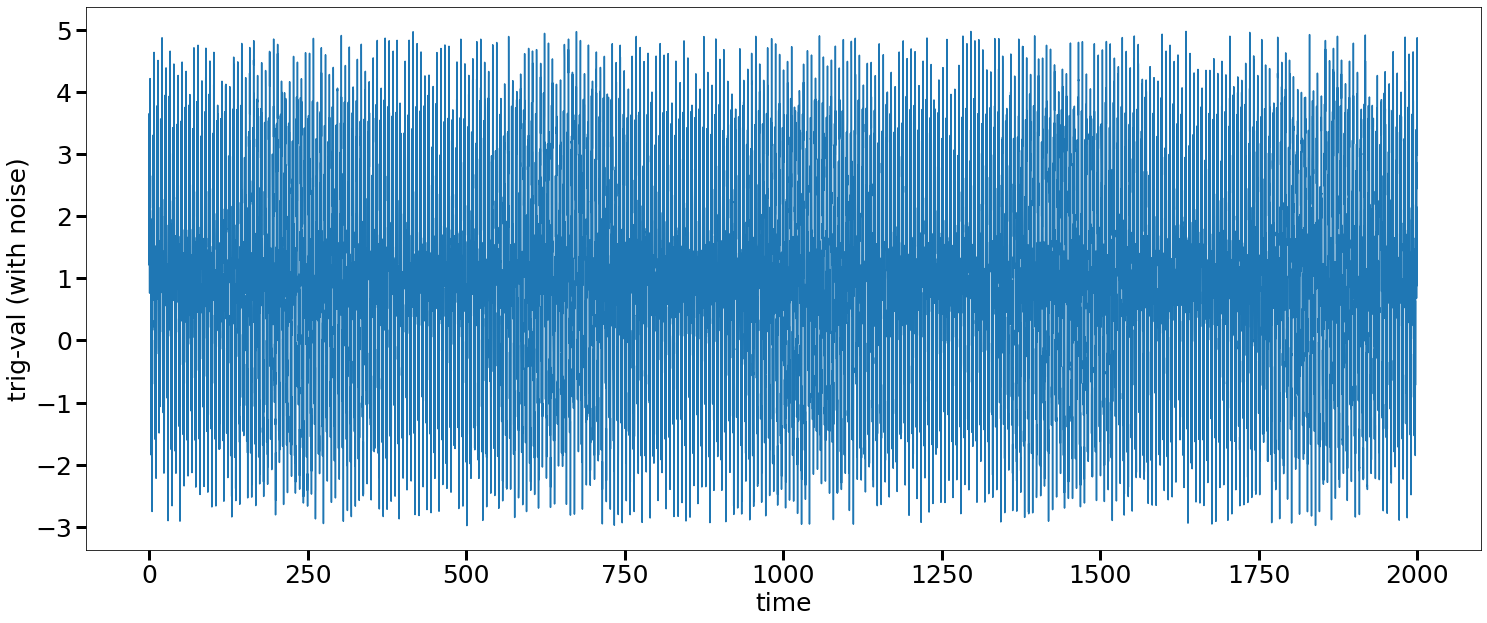

In [260]:
plt.figure(figsize=(25,10))
#plt.scatter(t, trig_data, marker='x')
plt.plot(t, trig_data_original)
plt.tick_params(axis='both', which='major', labelsize=25,length=10,width=3)
plt.xlabel(xlabel='time', size='25')
plt.ylabel(ylabel='trig-val (with noise)', size='25')
plt.show()

## Single Step Model: Predicts One data point into future

### Making appropriate training, testing data

> probably the most important part out of all this.

In [261]:
trig_data = np.copy(trig_data_original)

In [262]:
trig_series = pd.Series(data=trig_data, index=t, name="Trig Data")
train_end_index = int(len(trig_series) * 0.8); train_end_index

16000

In [263]:
# this code is directly from https://www.tensorflow.org/tutorials/structured_data/time_series

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
    
  return np.array(data), np.array(labels)

In [264]:
# time to scale these features and standardize using training data

train_data_mean = trig_data[:train_end_index].mean()
train_data_std = trig_data[:train_end_index].std()
print(train_data_mean, train_data_std)
trig_data = (trig_data - train_data_mean)/train_data_std

1.00948483802537 1.6566105015326131


In [265]:
# choose {trig_past_history} vals to use to predict {trig_future_target + 1} vals into the future
trig_past_history = 30
trig_future_target = 0

x_train_trig, y_train_trig = univariate_data(trig_data, 0, train_end_index, trig_past_history, trig_future_target)

x_val_trig, y_val_trig = univariate_data(trig_data, train_end_index, None, trig_past_history, trig_future_target)

In [270]:
print(x_train_trig.shape, y_train_trig.shape)
print(x_train_trig.shape[-2:])

(15970, 30, 1) (15970,)
(30, 1)


In [267]:
print(x_val_trig.shape, y_val_trig.shape)

(3970, 30, 1) (3970,)


Past history example:
 [[ 0.69455388]
 [ 0.82658215]
 [ 1.59758736]
 [ 1.26445829]
 [ 0.12206436]
 [ 0.96275244]
 [ 0.79291958]
 [ 0.12030663]
 [-0.14861373]
 [ 0.7942135 ]
 [ 0.36775251]
 [ 0.46868234]
 [ 0.55327146]
 [ 1.32618268]
 [ 1.10757292]
 [ 1.93711629]
 [ 1.82563884]
 [ 1.71802066]
 [ 1.2331025 ]
 [ 0.67738116]
 [ 0.84982515]
 [ 0.99281384]
 [-0.11305349]
 [ 0.57639527]
 [ 0.28559506]
 [ 0.32661056]
 [-0.09814649]
 [-0.09101806]
 [-0.32450111]
 [-0.75774559]]
using this history to predict the val:  -0.7217877348183139


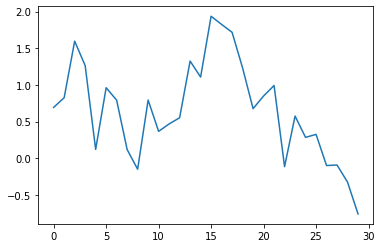

In [268]:
print("Past history example:\n", x_train_trig[0])
print("using this history to predict the val: ", y_train_trig[0])
plt.plot(x_train_trig[0])

In [272]:
# much of below code is derived from https://www.tensorflow.org/tutorials/structured_data/time_series

BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_trig = tf.data.Dataset.from_tensor_slices((x_train_trig, y_train_trig))
train_trig = train_trig.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_trig = tf.data.Dataset.from_tensor_slices((x_val_trig, y_val_trig))
val_trig = val_trig.batch(BATCH_SIZE).repeat()

In [273]:
# creating the neural network model

lstm_prediction_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_trig.shape[-2:]),
    tf.keras.layers.Dense(1)
])

In [274]:
lstm_prediction_model.compile(optimizer='adam', loss='mae')

In [276]:
lstm_prediction_model.fit(train_trig, epochs=10, steps_per_epoch=250, validation_data=val_trig, validation_steps=50)

Train for 250 steps, validate for 50 steps
Epoch 1/10
250/250 [==============================] - 16s 64ms/step - loss: 0.5592 - val_loss: 0.4161
Epoch 2/10
250/250 [==============================] - 13s 52ms/step - loss: 0.3657 - val_loss: 0.3446
Epoch 3/10
250/250 [==============================] - 13s 53ms/step - loss: 0.3346 - val_loss: 0.3288
Epoch 4/10
250/250 [==============================] - 13s 53ms/step - loss: 0.3257 - val_loss: 0.3278
Epoch 5/10
250/250 [==============================] - 13s 53ms/step - loss: 0.3224 - val_loss: 0.3244
Epoch 6/10
250/250 [==============================] - 13s 54ms/step - loss: 0.3200 - val_loss: 0.3196
Epoch 7/10
250/250 [==============================] - 13s 54ms/step - loss: 0.3197 - val_loss: 0.3186
Epoch 8/10
250/250 [==============================] - 14s 55ms/step - loss: 0.3187 - val_loss: 0.3196
Epoch 9/10
250/250 [==============================] - 13s 54ms/step - loss: 0.3177 - val_loss: 0.3169
Epoch 10/10
250/250 [==================

In [277]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

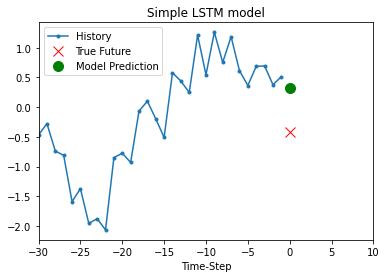

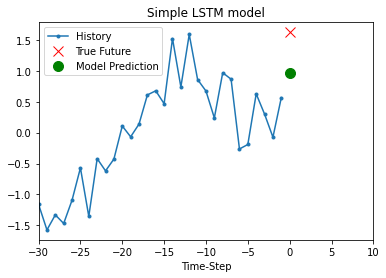

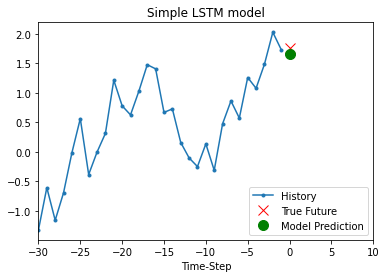

In [280]:
for x, y in val_trig.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    lstm_prediction_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()